In [1]:
import os
import sys
import numpy as np
import itertools
import time
import matplotlib.pyplot as plt
from math import pi
import h5py
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
import orbithunter as orb

# Developer Guide

This notebook acts to serve as an interactive example of the [developer's guide](https://orbithunter.readthedocs.io/en/latest/guide.html). It's goal is to show how easy it is to implement your equations,
and the relatively small number of functions and methods required to yield access to all of the tools that orbithunter provides. To do so I will work with the Lorenz equation; a dynamical system defined for the coordinates `(x, y, z)`. In the
spatiotemporal formulation, only `t` is a continuous dimension; x, y, z are coupled bit their concatenation does not correspond to a continuous field dimension. Therefore, for every orbit, the discretization will be represented by an array of dimension
$(N, 3)$. This is a simple example of a non-trivial system. Additionally, I have only experienced good results with spectral methods, an implicity assumption of the code. 

To break this down into pieces, I will first define all required functions ***outside*** of the class definition, and then collect them all at the end.

\begin{eqnarray}
 \dot{x} = \sigma(y-x) \\
 \dot{y} = \rho x - y - xz \\
 \dot{z} = xy - bz
\end{eqnarray}

The equations will be solved as a system of differential algebraic equations

\begin{eqnarray}
 \omega_j \tilde{x} - \sigma(\tilde{y} - \tilde{x}) = 0 \\
 \omega_j \tilde{y} - \rho \tilde{x} + \tilde{y} + \mathcal{F}(x \cdot z) = 0 \\
 \omega_j \tilde{z} - \mathcal{F}(x\cdot y) + b \tilde{z} = 0
\end{eqnarray}

Where it is understood that $x\cdot y$ is the nonlinear term computed as a product in physical space and variables
marked by $~$ are The temporal Fourier modes of the coordinates $(x, y, z)$

The defaults are set such that $t\in(0, 100), \sigma=10,\rho=20, b=8/3$


# Static methods

These methods contain labels, shapes, etc.



We can now move onto the methods which actually evaluate the functions. I will
be working under the assumption that the default cost function is to be used:
$\frac{F^2}{2}$. We must implement the transforms first. Because we have parameters which are real-valued, it will benefit us to make the equations real valued.

In [2]:
from scipy.fft import rfft, irfft

In [3]:
import numpy as np

In [19]:
class TestOrbit(orb.Orbit):

    def transform(self, to=None):
        if self.state is None:
            raise ValueError(
                "Trying to transform an unpopulated {} instance.".format(str(self))
            )
        elif self.basis is None:
            raise ValueError(
                "Trying to transform state with unknown basis".format(str(self))
            )

        if to == "physical":
            if self.basis == "spectral":
                return self._inv_time_transform()
            else:
                return self
        elif to == "spectral":
            if self.basis == "physical":
                return self._time_transform()
            else:
                return self
        else:
            raise ValueError("Trying to transform to unrecognized basis.")

    def _time_transform(self):

        xyz = self.state
        modes = rfft(xyz, axis=0, norm='ortho')
        # do not include nyquist frequency (last row)
        modes = np.concatenate((modes.real[:-1, :], modes.imag[1:-1, :]), axis=0)
        # So that F^T = F^{-1}
        modes[1:, :] = np.sqrt(2) * modes[1:, :]
        return self.__class__(**{**vars(self), 'state':modes, 'basis':"spectral"})

    def _inv_time_transform(self):
        # Take rfft, accounting for unitary normalization.
        # Take rfft, accounting for unitary normalization.
        modes = self.state.astype(complex)
        if modes.shape[0] > 1:
            modes[1 : -max([int(self.n // 2) - 1, 1]), :] += (
                1j * modes[-max([int(self.n // 2) - 1, 1]) :, :]
            )
            # if first statement evaluates to zero, then take all rows of
            # axis by providing None as end of slice.
            n_rows = (-max([int(self.n // 2) - 1, 1]) + 1) or None
            modes = modes[:n_rows, :]
            modes[1:, :] /= np.sqrt(2)
            if modes.shape[0] == 1:
                modes = np.pad(modes, ((0, 1), (0, 0)))
            modes[-1, :] = 0
        else:
            if modes.shape[0] == 1:
                modes = np.pad(modes, ((0, 1), (0, 0)))
            modes[-1, :] = 0
        xyz = irfft(modes, axis=0, norm='ortho')
        return self.__class__(**{**vars(self), 'state':xyz, 'basis':"physical"})
    
    @staticmethod
    def bases_labels():
        return "physical", "spectral"
    
    @staticmethod
    def parameter_labels():
        return 't', 'sigma', 'rho', 'b'
    
    @staticmethod
    def discretization_labels():
        """
        Labels for time and spatial dimensions; space is treated as a vector of 3 
        coordinates

        """
        return 'n', 'ijk'
    
    @staticmethod
    def dimension_labels():
        return 't', 'x'
    
    @staticmethod
    def minimal_shapes():
        return 2, 3
    
    @staticmethod
    def minimal_shape_increments():
        return 1, 0
    
    @staticmethod
    def continuous_dimensions():
        return True, False

    @staticmethod
    def default_shape():
        return (4, 3)

    @staticmethod
    def _default_parameter_ranges():
        return {'t': (0, 100), 'sigma':10, 'rho':28, 'b':8./3.}
    
    @staticmethod
    def default_constraints():
        return {'t': False, 'sigma':True, 'rho': True, 'b':True}
    
    @classmethod
    def _dimension_indexing_order(cls):
        return False, True
    
    def _pad(self, size, axis=0):
        """
        Increase the size of the discretization via zero-padding

        Parameters
        ----------
        size : int
            The new size of the discretization, must be an even integer
            larger than the current size of the discretization (handled by resize method).

        axis : int
            The dimension of the state that will be padded.

        Returns
        -------
        OrbitKS :
            OrbitKS instance with larger discretization.

        Notes
        -----
        Need to account for the normalization factors by multiplying by old, dividing by new.

        """
        modes = self.transform(to="spectral")
        if axis == 0:
            # Due to formatting, can prepend and append zeros to second half as opposed to appending
            # to first and second halves.
            padding = (size - modes.n) // 2
            padding_tuple = ((padding, padding), (0, 0))
            padded_modes = np.concatenate(
                (
                    modes.state[: -(modes.n // 2 - 1), :],
                    np.pad(modes.state[-(modes.n // 2 - 1) :, :], padding_tuple),
                ),
                axis=0,
            )
            padded_modes *= np.sqrt(size / modes.n)
            return self.__class__(
                **{
                    **vars(self),
                    "state": padded_modes,
                    "basis": "modes",
                    "discretization": (size, self.m),
                }
            ).transform(to=self.basis)

        else:
            return self
            
    def _truncate(self, size, axis=0):
        """
        Decrease the size of the discretization via truncation

        Parameters
        ----------
        size : int
            The new size of the discretization, must be an even integer
            smaller than the current size of the discretization (handled by resize method).

        axis : int
            The dimension of the state that will be truncated.

        Returns
        -------
        OrbitKS :
            OrbitKS instance with smaller discretization.

        Notes
        -----
        Need to account for the normalization factors by multiplying by old, dividing by new.

        """
        modes = self.transform(to="spectral")
        if axis == 0:
            truncate_number = int(size // 2) - 1
            # Split into real and imaginary components, truncate separately.
            first_half = modes.state[: truncate_number + 1, :]
            second_half = modes.state[
                -(modes.n // 2 - 1) : -(modes.n // 2 - 1) + truncate_number, :
            ]
            truncated_modes = np.sqrt(size / modes.n) * np.concatenate(
                (first_half, second_half), axis=0
            )
            return self.__class__(
                **{
                    **vars(self),
                    "state": truncated_modes,
                    "basis": "modes",
                    "discretization": (size, self.m),
                }
            ).transform(to=self.basis)
        else:
            return self
        
    def plot(self):
        from mpl_toolkits import mplot3d
        import numpy as np
        import matplotlib.pyplot as plt

        fig = plt.figure()
        ax = plt.axes(projection='3d')
        xyz = self.transform(to='physical').state
        ax.plot3D(xyz[:,0], xyz[:, 1], xyz[:, 2], 'gray')
        plt.show()


In [20]:
fake_xyz = np.concatenate((np.cos(2*pi/8 *np.arange(8))[:, None],
                           np.cos(2*pi/8 *np.arange(8))[:, None],
                           np.sin(2*pi/8 *np.arange(8))[:, None]), axis=1)

In [27]:
orbit = TestOrbit(state=fake_xyz, basis="physical")

To check the transforms, let's look at the non-zero modes and how they
arrange real, imaginary components. Because of how the dummy trajectory
was made, there should only be 1 nonzero component per coordinate; imaginary
corresponds to sine, real corresponds to cosine.

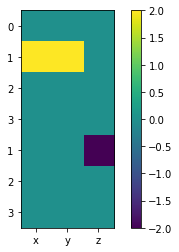

In [28]:
plt.figure()
plt.imshow(orbit.transform(to='spectral').state)
plt.colorbar()
plt.xticks((0, 1, 2), labels=('x', 'y', 'z'))
plt.yticks(range(7), (0, 1, 2, 3, 1, 2, 3))
plt.show()

In [31]:
orbit = orbit.populate(attr='parameters')

We can now plot in 3-d! 

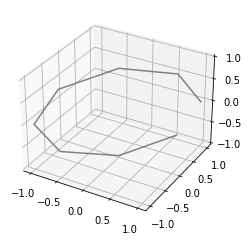

In [33]:
orbit.plot()

In [34]:
orbit.orbit_vector()

array([[ 1.00000000e+00],
       [ 1.00000000e+00],
       [ 0.00000000e+00],
       [ 7.07106781e-01],
       [ 7.07106781e-01],
       [ 7.07106781e-01],
       [ 6.12323400e-17],
       [ 6.12323400e-17],
       [ 1.00000000e+00],
       [-7.07106781e-01],
       [-7.07106781e-01],
       [ 7.07106781e-01],
       [-1.00000000e+00],
       [-1.00000000e+00],
       [ 1.22464680e-16],
       [-7.07106781e-01],
       [-7.07106781e-01],
       [-7.07106781e-01],
       [-1.83697020e-16],
       [-1.83697020e-16],
       [-1.00000000e+00],
       [ 7.07106781e-01],
       [ 7.07106781e-01],
       [-7.07106781e-01],
       [ 5.31165709e+01],
       [ 1.00000000e+01],
       [ 2.80000000e+01],
       [ 2.66666667e+00]])